<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Calculate-and-Record-Matchup-Matrix-for-RAPM" data-toc-modified-id="Calculate-and-Record-Matchup-Matrix-for-RAPM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate and Record Matchup Matrix for RAPM</a></span></li><li><span><a href="#Calculate-RAPM-for-Each-Player-from-Ridge-Regression-Coefficients" data-toc-modified-id="Calculate-RAPM-for-Each-Player-from-Ridge-Regression-Coefficients-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate RAPM for Each Player from Ridge Regression Coefficients</a></span></li><li><span><a href="#Explore-Correlations-of-Advanced-Stats-with-RAPM" data-toc-modified-id="Explore-Correlations-of-Advanced-Stats-with-RAPM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Explore Correlations of Advanced Stats with RAPM</a></span></li><li><span><a href="#Calculate-Lineup-RAPM-Based-on-Sum-of-Players" data-toc-modified-id="Calculate-Lineup-RAPM-Based-on-Sum-of-Players-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculate Lineup RAPM Based on Sum of Players</a></span></li><li><span><a href="#Exploring-RAPM-Based-Lineup-Impact" data-toc-modified-id="Exploring-RAPM-Based-Lineup-Impact-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exploring RAPM-Based Lineup Impact</a></span></li></ul></div>

In [1]:
import numpy as np
import time
import sys
import os
import pandas as pd
from functools import reduce
from operator import itemgetter
import itertools
import re
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import seaborn as sns
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
from scipy import signal
from scipy.stats import gaussian_kde
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [2]:
sns.set_style("whitegrid")

# Load Data

In [4]:
dfp = pd.read_csv('../CompleteNBAPlayerStats.csv')

dfp = dfp[dfp.year.astype(int) != 2020]
dfp = dfp.groupby(['name'], as_index=False).mean()
dfp


,name,year,GP,GS,height,weight,actual_draft_year,draft_round,draft_number,draft_year,...,OFF_SCORE_FREQ_MISC,OFF_PERC_MISC,AVG_OPP_FGP,WAVG_OPP_FGP,AVG_OPP_PPH,WAVG_OPP_PPH,ORPM,DRPM,RPM,RPM_WINS
0,Aaron Brooks,2016.5,67.000000,0.000000,72.0,161.0,2007.0,1.0,26.0,2008.0,...,0.23300,0.346500,0.433357,0.414559,0.988571,94.762339,-1.055000,-1.7300,-2.785000,0.245000
1,Aaron Gordon,2017.5,73.500000,61.000000,81.0,220.0,2014.0,1.0,4.0,2015.0,...,0.31750,0.612000,0.379429,0.388641,0.846429,86.704883,0.490000,0.1825,0.672500,5.282500
2,Aaron Holiday,2019.0,50.000000,0.000000,73.0,185.0,2018.0,1.0,23.0,2019.0,...,0.31800,0.449000,0.259857,0.352813,0.615714,78.995722,-1.110000,-0.4000,-1.510000,0.660000
3,Al Horford,2017.5,72.500000,72.500000,82.0,245.0,2007.0,1.0,3.0,2008.0,...,0.22025,0.333000,0.338607,0.400482,0.754286,88.576181,1.157500,2.1200,3.277500,9.145000
4,Al Jefferson,2017.5,51.000000,1.000000,82.0,265.0,2004.0,1.0,15.0,2005.0,...,0.11900,0.228500,0.268286,0.479759,0.587143,105.689753,-1.390000,0.2550,-1.135000,0.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Zach Collins,2019.0,77.000000,0.000000,84.0,230.0,2017.0,1.0,10.0,2018.0,...,0.22600,0.341000,0.368429,0.419863,0.920000,105.236443,-1.460000,0.9300,-0.530000,2.110000
553,Zach LaVine,2017.5,54.000000,41.500000,77.0,183.0,2014.0,1.0,13.0,2015.0,...,0.23050,0.501250,0.372714,0.405130,0.849643,93.109490,-0.115000,-2.5025,-2.617500,0.700000
554,Zach Randolph,2017.0,66.666667,38.333333,81.0,270.0,2001.0,1.0,19.0,NaN,...,0.28300,0.559333,0.332095,0.417647,0.728095,91.881963,-0.326667,-1.4000,-1.726667,1.596667
555,Zaza Pachulia,2017.5,70.750000,49.750000,83.0,240.0,2003.0,2.0,42.0,NaN,...,0.16225,0.166500,0.298429,0.439961,0.590714,88.381973,-1.135000,2.6650,1.530000,3.887500


In [5]:
df = pd.read_csv('../NBA_Matchup_PlusMinus.csv', index_col=0)
df


,year,game,ht_lineup,vt_lineup,ht_stint_pm,vt_stint_pm,ht_stint_poss,ht_pm_ph,vt_pm_ph
0,2017,1,"JR Smith,Kevin Love,Kyrie Irving,LeBron James,...","Carmelo Anthony,Courtney Lee,Derrick Rose,Joak...",2,-2,63,3.174603,-3.174603
1,2017,1,"JR Smith,Kyrie Irving,LeBron James,Richard Jef...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",1,-1,12,8.333333,-8.333333
2,2017,1,"Iman Shumpert,Kyrie Irving,LeBron James,Richar...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",0,0,11,0.000000,0.000000
3,2017,1,"Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",4,-4,14,28.571429,-28.571429
4,2017,1,"Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...","Brandon Jennings,Courtney Lee,Justin Holiday,K...",0,0,4,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
98072,2019,1230,"Jake Layman,Meyers Leonard,Gary Trent Jr.,Anfe...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",7,-7,17,41.176471,-41.176471
98073,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",5,-5,6,83.333333,-83.333333
98074,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",4,-4,18,22.222222,-22.222222
98075,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","BJ Johnson,Corey Brewer,Frank Mason,Marvin Bag...",2,-2,7,28.571429,-28.571429


# Calculate and Record Matchup Matrix for RAPM

In [13]:
players = dfp.name.values
#print(players)

print('PBP lineup data contains', len(df), 'stints.')
player_arr = []
for index, stint in df.iterrows():
    #print(stint)
    player_arr += stint.ht_lineup.split(',')
player_arr = np.unique(player_arr)

f_players, f_players_ind, f_lineup_indices = np.intersect1d(players, player_arr, return_indices=True)
print('Found', len(f_players), 'common players between player database and PBP matchup data.')

net_diff = []
rapm_matrix = []
idx=0
for index, stint in df.iterrows():
    if idx%100 == 0:
        sys.stdout.write("\rOn Stint %i..." % (idx+1))
        sys.stdout.flush()
    net_diff.append(stint.ht_pm_ph)
    player_coeff = []
    #for player in f_players:
    for player in player_arr:
        if player in stint.ht_lineup:
            player_coeff.append(1)
        elif player in stint.vt_lineup:
            player_coeff.append(-1)
        else:
            player_coeff.append(0)
    rapm_matrix.append(player_coeff)
    idx += 1
    
rapm_matrix = np.array(rapm_matrix)
print('\n', rapm_matrix)


PBP lineup data contains 98077 stints.
Found 547 common players between player database and PBP matchup data.
On Stint 98001...
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
df_rapm = pd.DataFrame(rapm_matrix, columns=player_arr)
df_rapm.to_csv('NBA_RAPM_Data.csv')
df_rapm

,AJ Hammons,Aaron Brooks,Aaron Gordon,Aaron Harrison,Aaron Holiday,Abdel Nader,Adreian Payne,Al Horford,Al Jefferson,Al-Farouq Aminu,...,Yante Maten,Yogi Ferrell,Yuta Watanabe,Zach Collins,Zach LaVine,Zach Lofton,Zach Randolph,Zaza Pachulia,Zhaire Smith,Zhou Qi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
98073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98074,0,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
98075,0,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0


# Calculate RAPM for Each Player from Ridge Regression Coefficients

In [15]:
#x_train = df_rapm
x_train = rapm_matrix
y_train = net_diff
ridge_reg = Ridge(alpha=100)
ridge_reg.fit(x_train, y_train)


Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
#y_ridge_results = ridge_reg.predict(x_train)
#print(y_ridge_results)
#print(len(sorted(y_ridge_results, reverse=True)))

#print(len(ridge_reg.coef_))
player_rapm = ridge_reg.coef_

sorted_rapm_names = [x for _,x in sorted(zip(player_rapm, player_arr), reverse=True)]
print('Sorted RAPM for Each Player:')
for i,player in enumerate(sorted_rapm_names):
    if player in f_players:
        print(player, ':', sorted(player_rapm, reverse=True)[i])


Sorted RAPM for Each Player:
Damian Lillard : 3.6783960858723215
Stephen Curry : 3.457203250551691
Kyle Lowry : 2.9480384363332797
Ryan Broekhoff : 2.777500401337201
Jrue Holiday : 2.7534387241490106
Al Horford : 2.737433812271865
Nikola Jokic : 2.565418374584378
LeBron James : 2.430160906265632
Paul George : 2.413015823874074
Kevin Love : 2.383828192287062
Rudy Gobert : 2.3796801183799783
Chris Paul : 2.3628330942151905
James Harden : 2.351755269822508
Raul Neto : 2.3292779247381574
Chris McCullough : 2.1463347892362745
Joel Embiid : 2.137230501046421
Giannis Antetokounmpo : 2.109127391487587
Karl-Anthony Towns : 2.1012746700028027
Russell Westbrook : 2.09816699756718
Robert Covington : 2.094912181572256
Mike Conley : 2.031753157344309
Kemba Walker : 2.0293165234022084
Jimmy Butler : 2.0100725810148563
Marreese Speights : 2.00036069383921
Derrick White : 1.956818830344538
Marc Gasol : 1.9466626232255622
Bradley Beal : 1.9279924624525615
Kristaps Porzingis : 1.8979084212667134
Ryan Kel

In [ ]:
#print(len(f_lineup_indices), len(player_rapm))
#f_players_ind[-1]
#player_rapm[f_players_ind]
#dfp['RAPM'] = player_rapm[f_lineup_indices]

##### After adding new columns to dfp (player dataframe, bypassing redo of RAPM calc)
new_players = dfp.name.values
f_new_players, f_new_players_ind_left, f_new_players_ind_right = np.intersect1d(new_players, f_players, return_indices=True)
f_new_players_lineup, f_new_lineup_ind_left, f_new_lineup_ind_right = np.intersect1d(f_new_players, player_arr, return_indices=True)
#####

rapms = player_rapm[f_lineup_indices]

##### After adding new columns to dfp (player dataframe, bypassing redo of RAPM calc)
#dfp_new = dfp.iloc[f_players_ind, :]
#dfp_new['RAPM'] = player_rapm[f_lineup_indices]
dfp_new = dfp.iloc[f_new_players_ind_left, :]
dfp_new['RAPM'] = player_rapm[f_new_lineup_ind_right]
#####

dfp = dfp_new

print(dfp)


# Explore Correlations of Advanced Stats with RAPM

(24, -0.5)

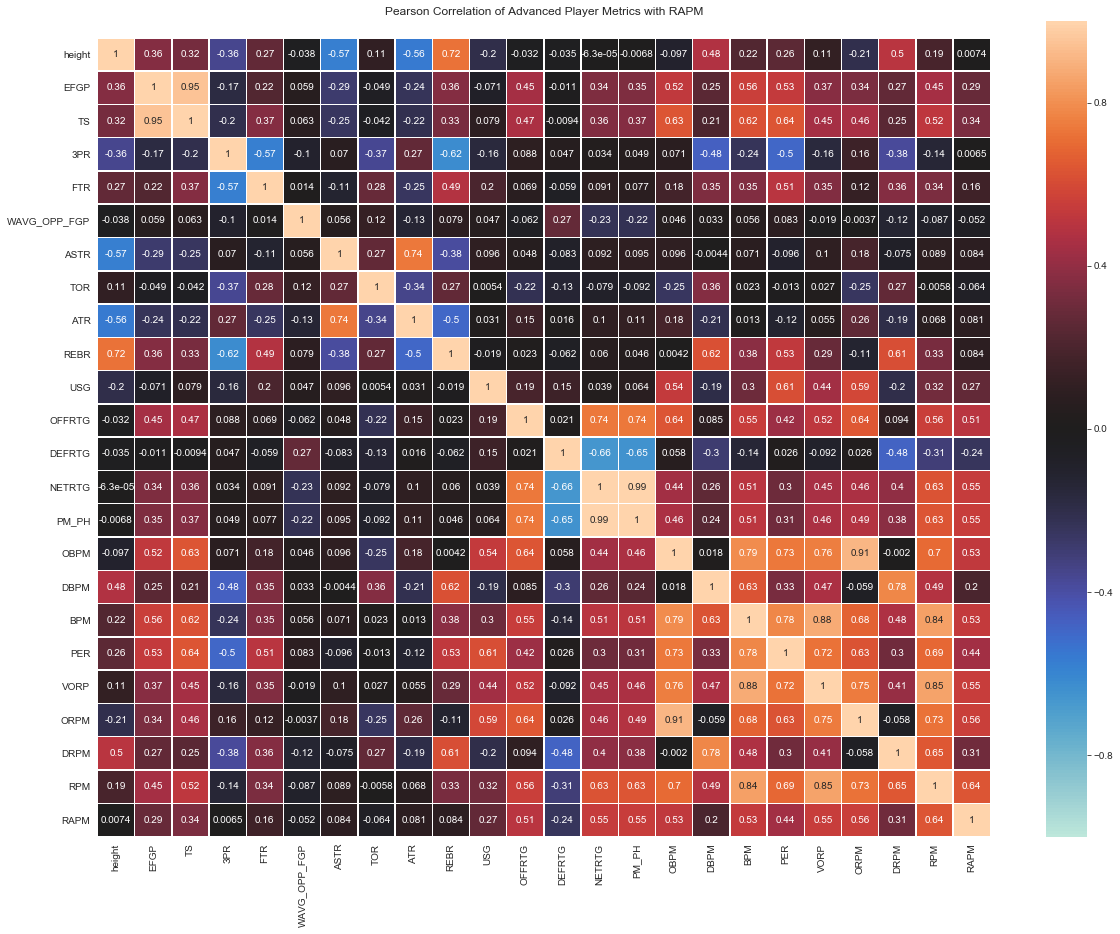

In [150]:
# Plot a Pearson correlation matrix for all relevant statistics to look for entangled variables
fig, ax = plt.subplots(figsize=(20, 15))
cols_to_inc = ['height', 'EFGP', 'TS', '3PR', 'FTR', 'WAVG_OPP_FGP', 'ASTR', 'TOR', 'ATR', 'REBR', 'USG', 'OFFRTG', 'DEFRTG', 'NETRTG', 'PM_PH', 'OBPM', 'DBPM', 'BPM', 'PER', 'VORP', 'ORPM', 'DRPM', 'RPM', 'RAPM']
features = dfp[cols_to_inc]
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns, 
            yticklabels=pc.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Advanced Player Metrics with RAPM")
ax.set_ylim(len(pc), -0.5)


(-6, 8)

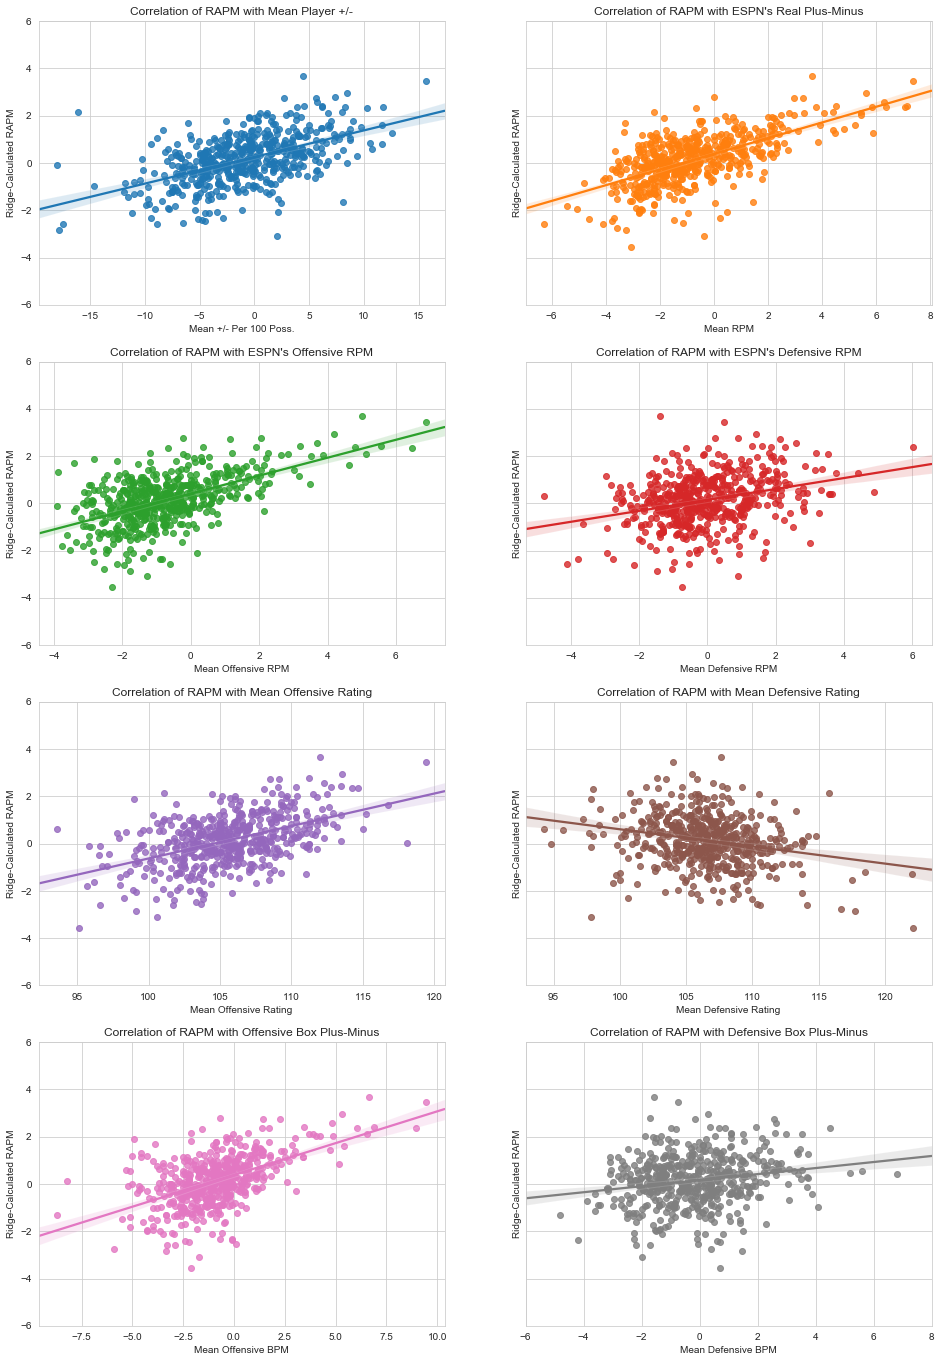

In [133]:
fig, ax = plt.subplots(4, 2, figsize=(16,24), sharey=True)

sns.regplot(x="PM_PH", y="RAPM", data=dfp[dfp.PM_PH>-20], ax=ax[0,0])
ax[0,0].set(xlabel='Mean +/- Per 100 Poss.', ylabel='Ridge-Calculated RAPM', title='Correlation of RAPM with Mean Player +/-')
ax[0,0].set_ylim(-6, 6)

sns.regplot(x="RPM", y="RAPM", data=dfp, ax=ax[0,1])
ax[0,1].set(xlabel='Mean RPM', ylabel='Ridge-Calculated RAPM', title="Correlation of RAPM with ESPN's Real Plus-Minus")

sns.regplot(x="ORPM", y="RAPM", data=dfp, ax=ax[1,0])
ax[1,0].set(xlabel='Mean Offensive RPM', ylabel='Ridge-Calculated RAPM', title="Correlation of RAPM with ESPN's Offensive RPM")

sns.regplot(x="DRPM", y="RAPM", data=dfp, ax=ax[1,1])
ax[1,1].set(xlabel='Mean Defensive RPM', ylabel='Ridge-Calculated RAPM', title="Correlation of RAPM with ESPN's Defensive RPM")

sns.regplot(x="OFFRTG", y="RAPM", data=dfp[dfp.OFFRTG > 90], ax=ax[2,0])
ax[2,0].set(xlabel='Mean Offensive Rating', ylabel='Ridge-Calculated RAPM', title='Correlation of RAPM with Mean Offensive Rating')

sns.regplot(x="DEFRTG", y="RAPM", data=dfp[dfp.DEFRTG>80], ax=ax[2,1])
ax[2,1].set(xlabel='Mean Defensive Rating', ylabel='Ridge-Calculated RAPM', title='Correlation of RAPM with Mean Defensive Rating')
#ax[1,1].set_xlim(90, 130)
#ax[1,1].set_ylim(-5, 5)

sns.regplot(x="OBPM", y="RAPM", data=dfp, ax=ax[3,0])
ax[3,0].set(xlabel='Mean Offensive BPM', ylabel='Ridge-Calculated RAPM', title='Correlation of RAPM with Offensive Box Plus-Minus')

sns.regplot(x="DBPM", y="RAPM", data=dfp, ax=ax[3,1])
ax[3,1].set(xlabel='Mean Defensive BPM', ylabel='Ridge-Calculated RAPM', title='Correlation of RAPM with Defensive Box Plus-Minus')
ax[3,1].set_xlim(-6, 8)


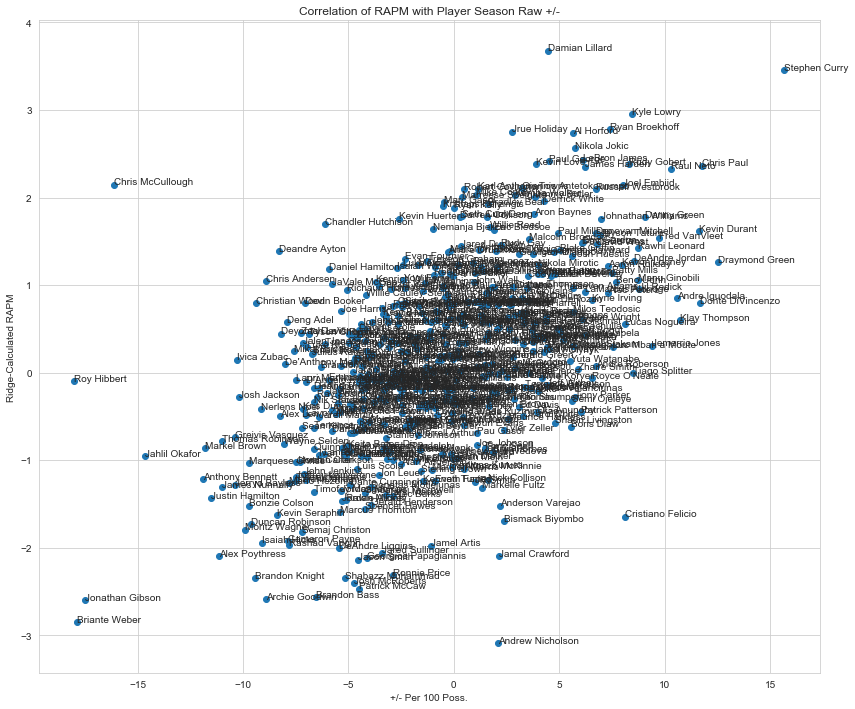

In [135]:
fig = plt.figure(figsize=(14,12))
plt.title('Correlation of RAPM with Player Season Raw +/-')
plt.xlabel('+/- Per 100 Poss.')
plt.ylabel('Ridge-Calculated RAPM')
plt.scatter(dfp[dfp.PM_PH>-20].PM_PH, dfp[dfp.PM_PH>-20].RAPM)
for i, txt in enumerate(dfp[dfp.PM_PH>-20].name):
    plt.annotate(txt, (dfp[dfp.PM_PH>-20].PM_PH.values[i], dfp[dfp.PM_PH>-20].RAPM.values[i]))
#plt.grid()

#left, right = plt.xlim()
#ydown, yup = plt.ylim()

#par = np.polyfit(dfp.PM_PH.values, dfp.RAPM.values, 1, full=True)
##print(par)
#slope=par[0][1]
#intercept=par[0][0]
##xl = [min(dfp.PM_PH.values), max(dfp.PM_PH.values)]
#xl = [-20, right]
#yl = [slope*xx + intercept for xx in xl]
#yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(dfp.PM_PH.values,dfp.RAPM.values)]
#par = np.polyfit(dfp.PM_PH.values, yerr, 2, full=True)
#yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(dfp.PM_PH.values,dfp.RAPM.values)]
#yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(dfp.PM_PH.values,dfp.RAPM.values)]
#plt.plot(xl, yl, 'r-', linewidth=3, label='Best Fit Line')
#pm_ph, yLow = zip(*sorted(zip(dfp.PM_PH.values, yerrLower)))
#plt.plot(pm_ph, yLow, 'r--', linewidth=3, label='Upper/Lower Error Bounds')
#pm_ph, yUpp = zip(*sorted(zip(dfp.PM_PH.values, yerrUpper)))
#plt.plot(pm_ph, yUpp, 'r--', linewidth=3)

#plt.xlim(left, right)
#plt.ylim(ydown, yup)
#plt.legend()
    

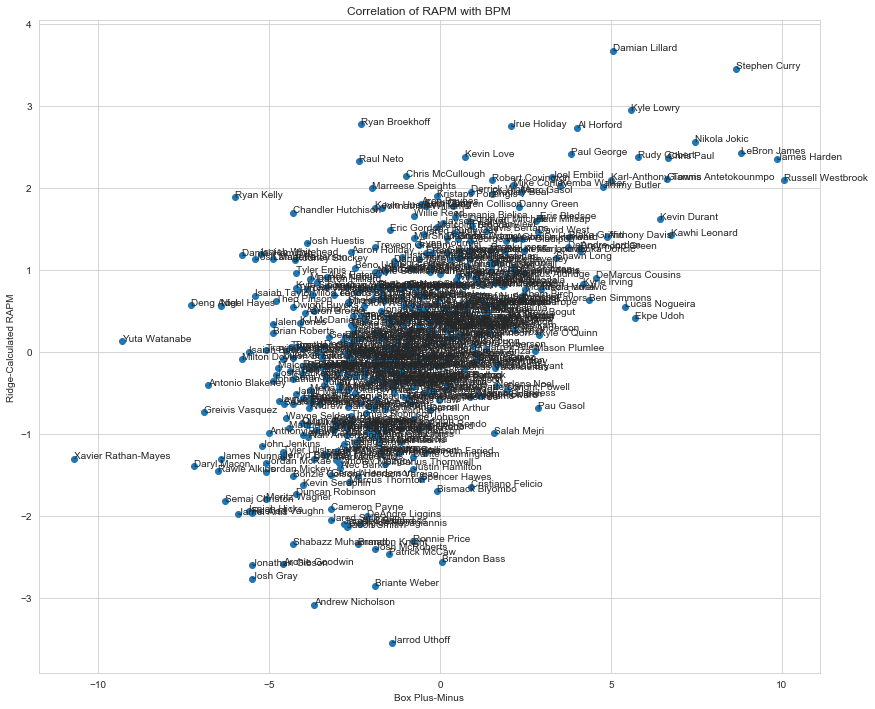

In [120]:
fig = plt.figure(figsize=(14,12))
plt.title('Correlation of RAPM with BPM')
plt.xlabel('Box Plus-Minus')
plt.ylabel('Ridge-Calculated RAPM')
plt.scatter(dfp.BPM, dfp.RAPM)
for i, txt in enumerate(dfp.name):
    plt.annotate(txt, (dfp.BPM.values[i], dfp.RAPM.values[i]))
#plt.grid()

#left, right = plt.xlim()
#ydown, yup = plt.ylim()

#par = np.polyfit(dfp.BPM.values, dfp.RAPM.values, 1, full=True)
##print(par)
#slope=par[0][1]
#intercept=par[0][0]
##xl = [min(dfp.BPM.values), max(dfp.BPM.values)]
#xl = [left, right]
#yl = [slope*xx + intercept for xx in xl]
#yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(dfp.BPM.values,dfp.RAPM.values)]
#par = np.polyfit(dfp.BPM.values, yerr, 2, full=True)
#yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(dfp.BPM.values,dfp.RAPM.values)]
#yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(dfp.BPM.values,dfp.RAPM.values)]
#plt.plot(xl, yl, 'r-', linewidth=3, label='Best Fit Line')
#pm_ph, yLow = zip(*sorted(zip(dfp.BPM.values, yerrLower)))
#plt.plot(pm_ph, yLow, 'r--', linewidth=3, label='Upper/Lower Error Bounds')
#pm_ph, yUpp = zip(*sorted(zip(dfp.BPM.values, yerrUpper)))
#plt.plot(pm_ph, yUpp, 'r--', linewidth=3)

#plt.xlim(left, right)
#plt.ylim(ydown, yup)


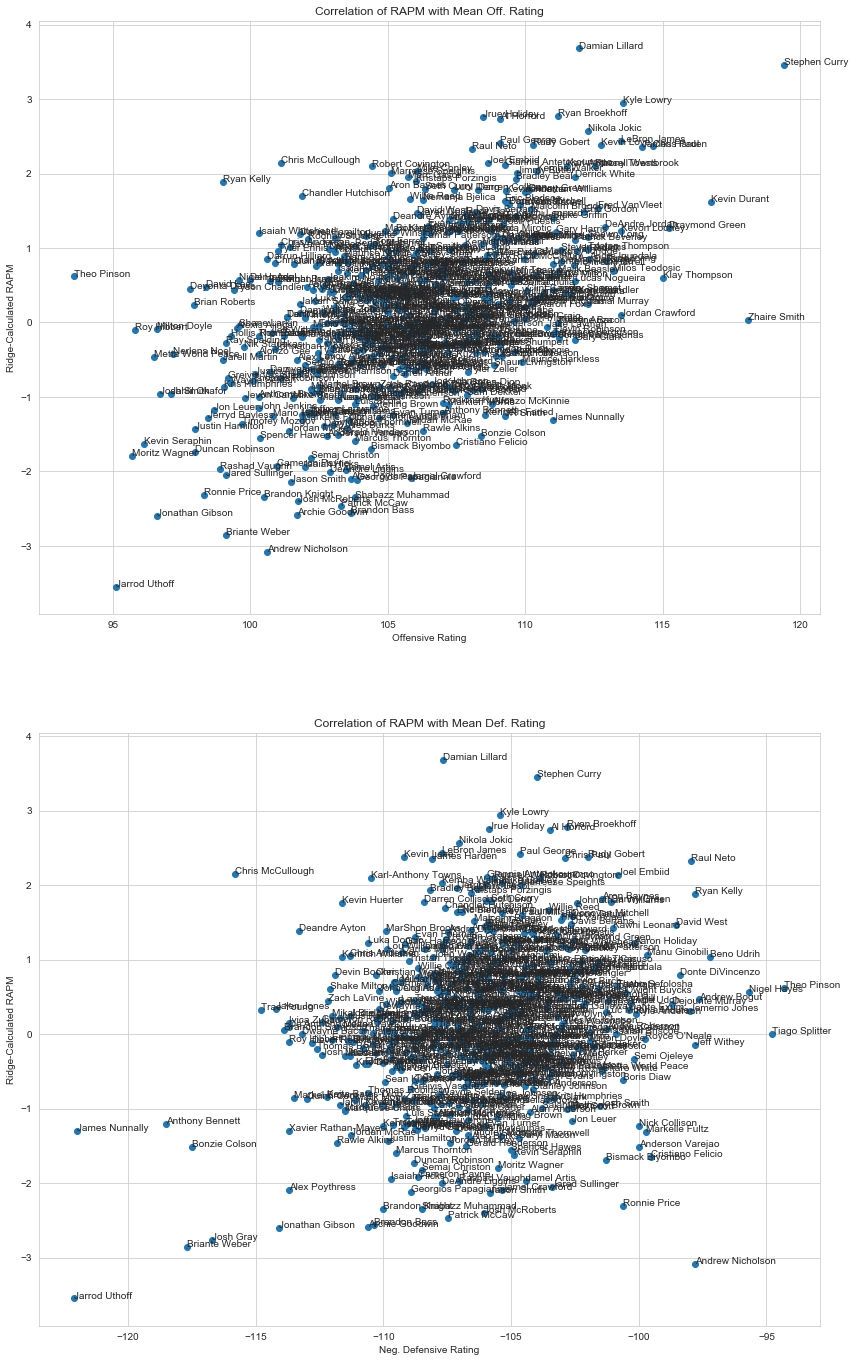

In [137]:
fig, ax = plt.subplots(2, 1, figsize=(14,24))

plt.axes(ax[0])

plt.title('Correlation of RAPM with Mean Off. Rating')
plt.xlabel('Offensive Rating')
plt.ylabel('Ridge-Calculated RAPM')
plt.scatter(dfp[dfp.OFFRTG > 90].OFFRTG, dfp[dfp.OFFRTG > 90].RAPM)
for i, txt in enumerate(dfp[dfp.OFFRTG > 90].name):
    plt.annotate(txt, (dfp[dfp.OFFRTG > 90].OFFRTG.values[i], dfp[dfp.OFFRTG > 90].RAPM.values[i]))
#plt.grid()

#left, right = ax[0].get_xlim()
#ydown, yup = ax[0].get_ylim()

#par = np.polyfit(dfp.OFFRTG.values, dfp.RAPM.values, 1, full=True)
##print(par)
#slope=par[0][0]
#intercept=par[0][1]
#print(slope, intercept)
##xl = [min(dfp.OFFRTG.values), max(dfp.OFFRTG.values)]
#xl = [left, right]
#yl = [slope*xx + intercept for xx in xl]
#yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(dfp.OFFRTG.values,dfp.RAPM.values)]
#par = np.polyfit(dfp.OFFRTG.values, yerr, 2, full=True)
#yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(dfp.OFFRTG.values,dfp.RAPM.values)]
#yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(dfp.OFFRTG.values,dfp.RAPM.values)]
#plt.plot(xl, yl, 'r-', linewidth=3, label='Best Fit Line')
#pm_ph, yLow = zip(*sorted(zip(dfp.OFFRTG.values, yerrLower)))
#plt.plot(pm_ph, yLow, 'r--', linewidth=3, label='Upper/Lower Error Bounds')
#pm_ph, yUpp = zip(*sorted(zip(dfp.OFFRTG.values, yerrUpper)))
#plt.plot(pm_ph, yUpp, 'r--', linewidth=3)

#ax[0].set_xlim(left, right)
#ax[1].set_ylim(ydown, yup)


plt.axes(ax[1])

plt.title('Correlation of RAPM with Mean Def. Rating')
plt.xlabel('Neg. Defensive Rating')
plt.ylabel('Ridge-Calculated RAPM')
plt.scatter(-dfp[dfp.DEFRTG>80].DEFRTG, dfp[dfp.DEFRTG>80].RAPM)
for i, txt in enumerate(dfp[dfp.DEFRTG>80].name):
    plt.annotate(txt, (-dfp[dfp.DEFRTG>80].DEFRTG.values[i], dfp[dfp.DEFRTG>80].RAPM.values[i]))
#plt.grid()

#left, right = plt.xlim()
#ydown, yup = plt.ylim()

#par = np.polyfit(-dfp.DEFRTG.values, dfp.RAPM.values, 1, full=True)
##print(par)
#slope=par[0][1]
#intercept=par[0][0]
##xl = [min(-dfp.DEFRTG.values), max(-dfp.DEFRTG.values)]
#xl = [left, right]
#yl = [slope*xx + intercept for xx in xl]
#yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(-dfp.DEFRTG.values,dfp.RAPM.values)]
#par = np.polyfit(-dfp.DEFRTG.values, yerr, 2, full=True)
#yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(-dfp.DEFRTG.values,dfp.RAPM.values)]
#yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(-dfp.DEFRTG.values,dfp.RAPM.values)]
#plt.plot(xl, yl, 'r-', linewidth=3, label='Best Fit Line')
#pm_ph, yLow = zip(*sorted(zip(-dfp.DEFRTG.values, yerrLower)))
#plt.plot(pm_ph, yLow, 'r--', linewidth=3, label='Upper/Lower Error Bounds')
#pm_ph, yUpp = zip(*sorted(zip(-dfp.DEFRTG.values, yerrUpper)))
#plt.plot(pm_ph, yUpp, 'r--', linewidth=3)

#plt.xlim(left, right)
#plt.ylim(ydown, yup)


# Calculate Lineup RAPM Based on Sum of Players

In [138]:
ht_lineup_RAPM = []
vt_lineup_RAPM = []
idx = 0

for index, stint in df.iterrows():
    if idx%100 == 0:
        sys.stdout.write("\rOn Stint %i..." % (idx+1))
        sys.stdout.flush()
    hl = stint.ht_lineup.split(',')
    vl = stint.vt_lineup.split(',')
    hRAPM = 0
    vRAPM = 0
    for hp in hl:
        if len(dfp[dfp.name == hp].RAPM) == 0:
            continue
        else:
            #print(dfp[dfp.name == hp].RAPM.values[0])
            hRAPM += dfp[dfp.name == hp].RAPM.values[0]
    for vp in vl:
        if len(dfp[dfp.name == vp].RAPM) == 0:
            continue
        else:
            #print(dfp[dfp.name == vp].RAPM.values[0])
            vRAPM += dfp[dfp.name == vp].RAPM.values[0]
    ht_lineup_RAPM.append(hRAPM)
    vt_lineup_RAPM.append(vRAPM)
    idx += 1

df['ht_lineup_RAPM'] = ht_lineup_RAPM
df['vt_lineup_RAPM'] = vt_lineup_RAPM

print(df)
    

On Stint 98001...       year  game                                          ht_lineup  \
0      2017     1  JR Smith,Kevin Love,Kyrie Irving,LeBron James,...   
1      2017     1  JR Smith,Kyrie Irving,LeBron James,Richard Jef...   
2      2017     1  Iman Shumpert,Kyrie Irving,LeBron James,Richar...   
3      2017     1  Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...   
4      2017     1  Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...   
...     ...   ...                                                ...   
98072  2019  1230  Jake Layman,Meyers Leonard,Gary Trent Jr.,Anfe...   
98073  2019  1230  Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...   
98074  2019  1230  Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...   
98075  2019  1230  Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...   
98076  2019  1230  Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...   

                                               vt_lineup  ht_stint_pm  \
0      Carmelo Anthony,Courtney Lee,Derrick R

In [139]:
df.to_csv('NBA_Matchup_PlusMinus_byLineup.csv')


In [143]:
dfh = df.copy()
dfv = df.copy()
dfh['lineup'] = dfh['ht_lineup']
dfh['pm_ph'] = dfh['ht_pm_ph']
dfh['lineup_RAPM'] = dfh['ht_lineup_RAPM']
dfh['num_poss'] = dfh['ht_stint_poss']
dfv['lineup'] = dfv['vt_lineup']
dfv['pm_ph'] = dfv['vt_pm_ph']
dfv['lineup_RAPM'] = dfv['vt_lineup_RAPM']
dfv['num_poss'] = dfv['ht_stint_poss']
dfh = dfh.groupby(['lineup'], as_index=False).mean()
dfv = dfv.groupby(['lineup'], as_index=False).mean()
#dfl = pd.merge(dfh, dfv, how='inner', on='lineup')
dfl = pd.concat((dfh, dfv))
dfl = dfl.groupby(dfl.lineup, as_index=False).mean()
dfl


,lineup,year,game,ht_stint_pm,vt_stint_pm,ht_stint_poss,ht_pm_ph,vt_pm_ph,ht_lineup_RAPM,vt_lineup_RAPM,pm_ph,lineup_RAPM,num_poss
0,"AJ Hammons,DeAndre Liggins,Devin Harris,Jarrod...",2017.0,1223.0,-2.000000,2.000000,4.0,-50.000000,50.000000,-1.448721,-4.068682,50.000000,-4.068682,4.0
1,"AJ Hammons,DeAndre Liggins,Dorian Finney-Smith...",2017.0,1223.0,-2.500000,2.500000,11.5,-23.106061,23.106061,-1.739852,-5.536045,23.106061,-5.536045,11.5
2,"AJ Hammons,DeAndre Liggins,Dorian Finney-Smith...",2017.0,1223.0,-1.000000,1.000000,14.5,-8.333333,8.333333,-2.026846,-4.479415,8.333333,-4.479415,14.5
3,"AJ Hammons,Deron Williams,Devin Harris,Dorian ...",2017.0,411.0,0.666667,-0.666667,7.0,8.095238,-8.095238,-0.369241,-0.226695,8.095238,-0.369241,7.0
4,"AJ Hammons,Deron Williams,Dorian Finney-Smith,...",2017.0,411.0,1.000000,-1.000000,4.0,25.000000,-25.000000,0.989975,-0.012214,25.000000,0.989975,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45829,"Zaza Pachulia,Langston Galloway,Stanley Johnso...",2019.0,321.0,0.000000,0.000000,34.0,-0.632340,0.632340,0.758717,0.414728,-0.632340,0.758717,34.0
45830,"Zaza Pachulia,Langston Galloway,Thon Maker,Ish...",2019.0,1186.0,4.000000,-4.000000,23.0,17.391304,-17.391304,1.012865,2.207472,-17.391304,2.207472,23.0
45831,"Zaza Pachulia,Luke Kennard,Langston Galloway,S...",2019.0,693.0,3.000000,-3.000000,42.0,7.142857,-7.142857,-0.593855,0.474147,-7.142857,0.474147,42.0
45832,"Zhaire Smith,Ben Simmons,Amir Johnson,Shake Mi...",2019.0,1212.0,0.000000,0.000000,40.0,0.000000,0.000000,3.138716,1.501294,0.000000,1.501294,40.0


# Exploring RAPM-Based Lineup Impact

(array([1.251e+03, 1.567e+03, 1.893e+03, 2.131e+03, 2.702e+03, 2.967e+03,
        3.144e+03, 3.429e+03, 3.254e+03, 3.104e+03, 2.388e+03, 2.464e+03,
        2.049e+03, 1.754e+03, 1.508e+03, 1.242e+03, 1.048e+03, 9.460e+02,
        7.590e+02, 6.620e+02, 1.840e+02, 5.940e+02, 5.030e+02, 4.360e+02,
        4.040e+02, 3.670e+02, 3.130e+02, 2.840e+02, 2.630e+02, 2.530e+02,
        2.160e+02, 1.880e+02, 1.860e+02, 1.590e+02, 1.420e+02, 1.220e+02,
        1.060e+02, 1.010e+02, 7.100e+01, 8.800e+01, 2.800e+01, 5.800e+01,
        6.400e+01, 4.700e+01, 5.600e+01, 3.800e+01, 4.900e+01, 3.400e+01,
        3.200e+01, 2.000e+01, 1.300e+01, 1.900e+01, 1.100e+01, 1.000e+01,
        1.800e+01, 1.100e+01, 1.700e+01, 1.200e+01, 1.000e+00, 1.100e+01,
        1.000e+00, 8.000e+00, 5.000e+00, 7.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

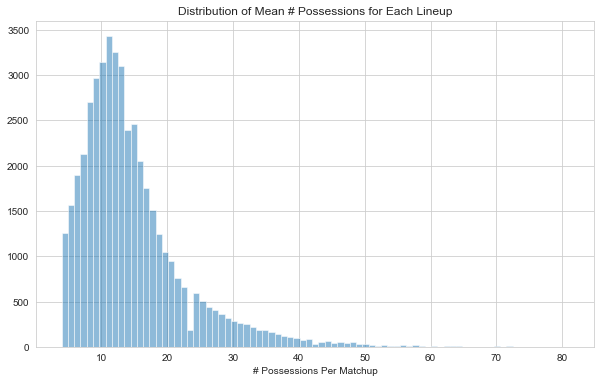

In [148]:
fig = plt.figure(figsize=(10,6))
plt.title('Distribution of Mean # Possessions for Each Lineup')
plt.xlabel('# Possessions Per Matchup')
plt.hist(dfl.num_poss, bins=dfl.num_poss.values.astype(int).max(), alpha=0.5)


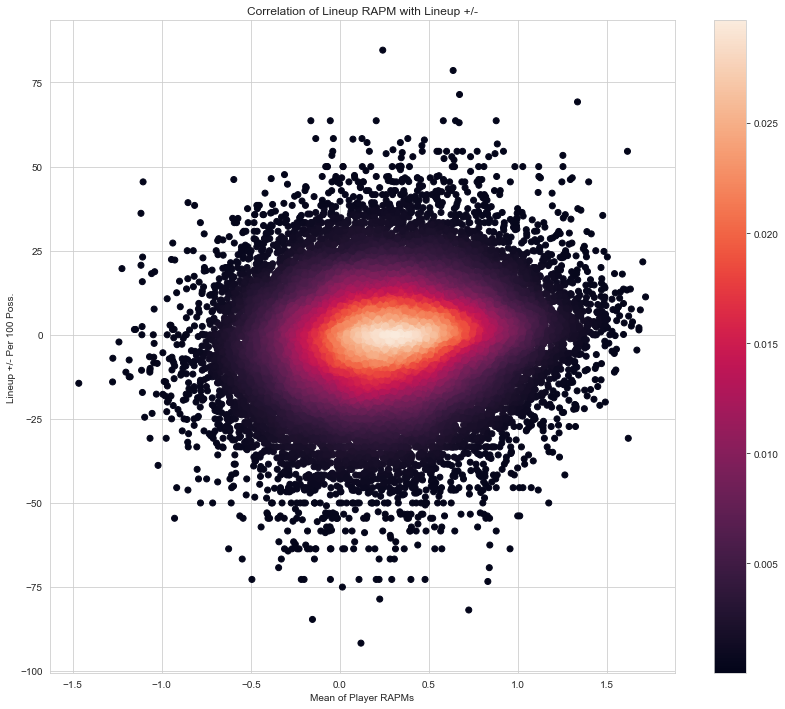

In [147]:
fig = plt.figure(figsize=(14,12))
plt.title('Correlation of Lineup RAPM with Lineup +/-')
plt.ylabel('Lineup +/- Per 100 Poss.')
plt.xlabel('Mean of Player RAPMs')
xy = np.vstack([dfl[dfl.num_poss>10].lineup_RAPM.values/5., dfl[dfl.num_poss>10].pm_ph.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dfl[dfl.num_poss>10].lineup_RAPM/5., dfl[dfl.num_poss>10].pm_ph, c=z)
plt.colorbar()
